In [5]:
from grid_world import *
from stage2skeletonv3 import *
import random as rd

from collections import deque
from IPython.display import clear_output

losses=[]
collisions_lst = []
ep_rewards = []
cycles_lst = []
eps_lst = []
action_set = {0: 'n', 1: 'w', 2: 'e', 3: 's'}
j= 0
collisions = 0
total_cycles = 0
i = 0 # epoch count

n = 5
m = 5

def train():

    global losses, collisions_lst, action_set, model, j, collisions, total_cycles, i, ep_rewards, cycles_lst, eps_lst, n, m

    gamma = 0.999
    # epsilon = 1.0
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.99997
    current_loss = 0

    epochs = 3200
    mem_size = 5000
    batch_size = 200
    replay = deque(maxlen=mem_size)
    max_moves = 100
    h = 0
    sync_freq = 400
    j=0
    # rewards=[]

    model = prepare_torch()

    num_agents = 4

    total_cycles = 0
    collisions = 0

    # initialise all configs and agents to optimize training performance

    loc_as = []
    loc_bs = []
    agents_each_epoch = []
    gws = []

    for i in range(epochs):
        
        loc_a = (rd.randint(0,n-1), rd.randint(0,m-1))
        # loc_a = global_loc_a
        # loc_b = (rd.randint(0,n-1), rd.randint(0,m-1))

        # loc_a = (0,3)
        # fix B
        loc_b = global_loc_b

        # ensuring loc_b and loc_a aren't equal
        while loc_b == loc_a:
            loc_b = rd.randint(0,n-1), rd.randint(0,m-1)
        
        loc_as.append(loc_a)
        loc_bs.append(loc_b)
        agents = init_agents( num_agents, loc_a, loc_b )
        agents_each_epoch.append( agents )
        # agents_each_epoch.append( init_agents_random( n, m, num_agents, loc_a ) )

        gws.append( GridWorld(n, m, loc_a, loc_b, agents) )

    # main loop 

    for i in range(epochs):

        loc_a = loc_as[i]
        loc_b = loc_bs[i]

        agents = agents_each_epoch[i]

        # a_b_switches = {}
        # for agent in agents:
        #     a_b_switches[agent.id] = 0

        gw = gws[i]

        steps = 0
        loop = True
        episode_reward = 0
        epoch_collisions = 0
        epoch_cycles = 0

        while loop and (steps < max_moves):

            # # change loop_agents to random order
            loop_agents = agents

            # rd.shuffle(loop_agents)
            
            for agent in loop_agents:

                # print(steps)
                # init_reached_a = agent.reached_a

                state1 = gw.get_np_state_for_agent(agent)
                steps += 1
                j += 1
                qvals = get_qvals(state1)

                if (rd.random() < epsilon):
                    action_ = rd.randint(0,3)
                else:
                    action_ = np.argmax(qvals)
                
                action = action_set[action_]
                
                reward = gw.attempt_action_for_agent(agent, action)

                state2 = gw.get_np_state_for_agent(agent)

                episode_reward += reward

                # if we consider pickup and dropoff as terminal condition - we dont - because agents need to learn infinite behavior
                # done = True if (a_b_switches[agent.id] >= 2) else False # both pickup and delivery at least once
                
                # if we consider 1 collision 
                # or num_steps over 25
                # as a terminal condition
                done = False
                if (agent.num_collisions > 0) or (agent.num_steps > 25):
                    done = True
                    # loop = False

                exp = (state1, action_, reward, state2, done)
                replay.append(exp)


                if (len(replay) > batch_size) and (j % 4 == 0):

                    # minibatch = rd.sample(replay, batch_size)
                    # states = [s1 for (s1,_,_,_,_) in minibatch]
                    # actions = [a for (_,a,_,_,_) in minibatch]
                    # targets = [TD_target(r, gamma, done, get_maxQ(s2)) for (_,_,r,s2,_) in minibatch]
                    # current_loss = train_one_step(states, actions, targets, gamma)
                    # losses.append(current_loss)
                    
                    minibatch = rd.sample(replay, batch_size)  # Sample as a list of tuples
                    states = np.stack([exp[0] for exp in minibatch])
                    actions = np.array([exp[1] for exp in minibatch], dtype=int)
                    rewards = np.array([exp[2] for exp in minibatch], dtype=np.float32)
                    next_states = np.stack([exp[3] for exp in minibatch])
                    dones = np.array([exp[4] for exp in minibatch], dtype=int)
                    q_max_next_states = get_maxQ(next_states)
                    # q_max_next_states = model2(next_states).max(dim=1).values 
                    targets = TD_target(rewards, gamma, dones, q_max_next_states)
                    current_loss = train_one_step(states, actions, targets, gamma)
                    losses.append(current_loss)

                if j % sync_freq == 0:
                    print(i, "cycles:", total_cycles, " loss:", current_loss, "total collisions:", collisions, "epoch_collisions:", epoch_collisions)
                    print(f"episode_reward: {episode_reward} steps: {steps} epoch_cycles: {epoch_cycles} epsilon: {epsilon}")
                    print()
                    clear_output(wait=True)
                    update_target()
            
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            epoch_collisions = sum([agent.num_collisions for agent in loop_agents])
            epoch_cycles = sum([agent.cycles for agent in loop_agents])

            if steps > max_moves:
                loop = False
                steps = 0
                break

        for agent in agents:
            collisions += epoch_collisions
        
        ep_rewards.append(episode_reward)
        collisions_lst.append(epoch_collisions)
        cycles_lst.append(epoch_cycles)
        total_cycles += epoch_cycles
        eps_lst.append(epsilon)
        
        # clear_output(wait=True)  

    print(f"total epochs: {i}, total steps in training: {j}, total collisions: {collisions}, total a/b switches: {total_cycles}")

train()

# import cProfile
# cProfile.run("train()")

# trying False done = bad

total epochs: 3199, total steps in training: 320000, total collisions: 46524, total a/b switches: 36445


In [2]:
print(f"total epochs: {i}, total steps in training: {j}, total collisions: {collisions}, total a/b switches: {total_cycles}")
print(f"lr: {learning_rate}")

total epochs: 4199, total steps in training: 420000, total collisions: 69212, total a/b switches: 54560
lr: 0.0002


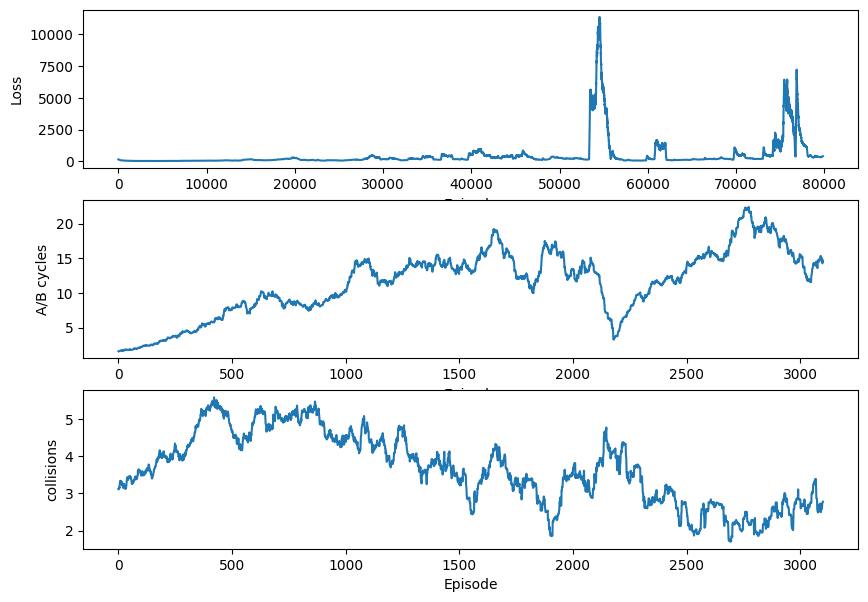

In [6]:
def moving_averages(arr, window_size):
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:
        window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

from matplotlib import pylab as plt

# plt.xlabel("Episode",fontsize=22)
# plt.ylabel("Loss",fontsize=22)
# plt.plot(np.array(losses))
# plt.figure(figsize=(10,7))

_, axs = plt.subplots(3, 1, figsize = (10,7))

# axs[0].plot(np.array(losses))
# axs[0].set_xlabel("Episode",fontsize=18)
# axs[0].set_ylabel("Loss",fontsize=18)

axs[0].plot(np.array(moving_averages(losses, 100)))
axs[0].set_xlabel("Episode",fontsize=10)
axs[0].set_ylabel("Loss",fontsize=10)

# axs[1].set_xlabel("Episode", fontsize=18)
# axs[1].set_ylabel("A/B switches", fontsize=18)
# axs[1].plot(np.array(a_b_switches_lst))

axs[1].set_xlabel("Episode", fontsize=10)
axs[1].set_ylabel("A/B cycles", fontsize=10)
axs[1].plot(np.array(moving_averages(cycles_lst, 100)))

# axs[2].set_xlabel("Episode", fontsize=18)
# axs[2].set_ylabel("collisions", fontsize=18)
# axs[2].plot(np.array(collisions_lst))

axs[2].set_xlabel("Episode", fontsize=10)
axs[2].set_ylabel("collisions", fontsize=10)
axs[2].plot(moving_averages(collisions_lst, 100))

plt.show()

Text(0, 0.5, 'Epsilon')

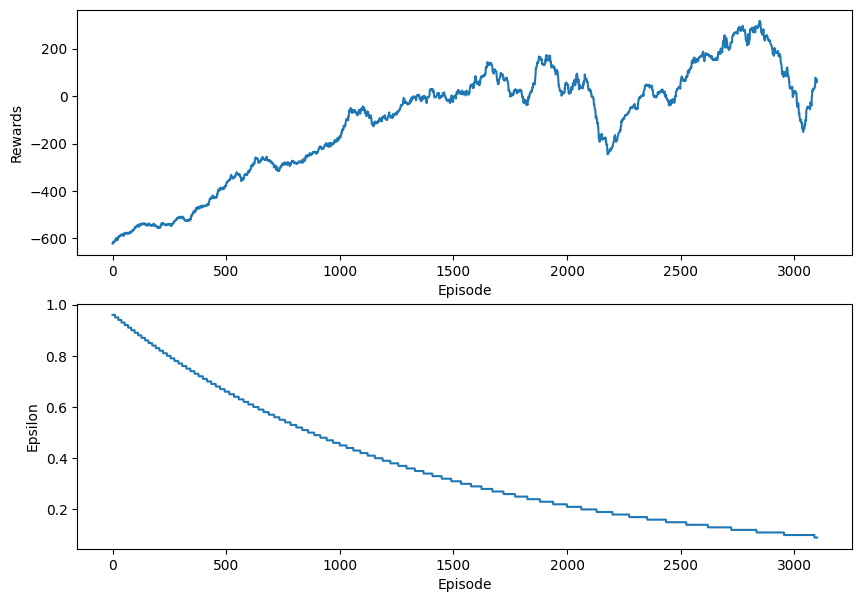

In [7]:
## rewards

# plt.xlabel("Episode",fontsize=12)
# plt.ylabel("Rewards",fontsize=12)
# plt.plot(np.array(moving_averages(ep_rewards,100)))
# plt.figure(figsize=(10,7))

_, axs = plt.subplots(2, 1, figsize = (10,7))

axs[0].plot(np.array(moving_averages(ep_rewards, 100)))
axs[0].set_xlabel("Episode",fontsize=10)
axs[0].set_ylabel("Rewards",fontsize=10)

axs[1].plot(np.array(moving_averages(eps_lst, 100)))
axs[1].set_xlabel("Episode",fontsize=10)
axs[1].set_ylabel("Epsilon",fontsize=10)

In [26]:
def test_once(model, loc_a, loc_b, display=True):

    n = 5
    m = 5

    max_steps = 25

    # 1st agent always begins at B
    agents = init_agents(4, loc_a, loc_b)

    gw = GridWorld(n, m, loc_a, loc_b, agents)

    focal_agent_idx = 0

    states_ = [gw.get_np_state_for_agent(agent).reshape(1, statespace_size) for agent in agents]
    states = [torch.from_numpy(state_).float() for state_ in states_]

    if display:
        print("initial state:")
        gw.display()
        print("focal agent is", agents[focal_agent_idx].id)

    for s in range( (len(agents)*25) + 1 ):

        for idx in range(len(agents)):

                qval = model(states[idx])
                qval_ = qval.data.numpy()
                action_ = np.argmax(qval_)
                action = action_set[action_]

                rew = gw.attempt_action_for_agent(agents[idx], action)

                if display:
                    print(f"agent {agents[idx].id} took action {action} and got rewarded {rew}")
                    print(gw.display())
                
                state_ = gw.get_np_state_for_agent(agents[idx]).reshape(1, statespace_size)
                state = torch.from_numpy(state_).float()
                states[idx] = state
        
        # whichever if condition is met first will return
        if (agents[focal_agent_idx].num_steps > max_steps):
            if display:
                print("test unsuccessful - too many steps")
            return False
        
        if (agents[focal_agent_idx].num_collisions > 0):
            if display:
                print("test unsuccessful - focal agent collided with an agent of the opposite type")
            return False

        if (agents[focal_agent_idx].reached_a):
            if display:
                print(f"test success - focal agent {agents[focal_agent_idx].id} reached A without collisions in under 25 steps")
            return True

    # ideally this line must never execute - if conditions should handle everything
    return False


In [27]:
loc_a = ( rd.randint(0,4), rd.randint(0,4) )
# loc_b = ( rd.randint(0,4), rd.randint(0,4) )

# loc_a = (0,3)
# loc_a = global_loc_a
# fixed B
loc_b = global_loc_b

test_once(model, loc_a, loc_b, True)

initial state:
 ----------------
|                |
|           A    |
|                |
|                |
|              B |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
1 (4, 4) False | 2 (4, 4) False | 3 (4, 4) False | 4 (4, 4) False | 
focal agent is 1
agent 1 took action w and got rewarded -1
 ----------------
|                |
|           A    |
|                |
|                |
|          *1  B |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
1 (4, 3) False | 2 (4, 4) False | 3 (4, 4) False | 4 (4, 4) False | 
None
agent 2 took action w and got rewarded -1
 ----------------
|                |
|           A    |
|                |
|                |
|          *2  B |
 ----------------
* followed by a number indicates the presence of a number of agents 

True

In [32]:
def test_stats(model):
  max_games = 1000
  wins = 0
  for i in range(max_games):
      
      loc_a = ( rd.randint(0,4), rd.randint(0,4) )
      # loc_a = global_loc_a
      # loc_b = ( rd.randint(0,4), rd.randint(0,4) )

      # fixed B
      loc_b = loc_b = global_loc_b

      while loc_b == loc_a:
         loc_b = ( rd.randint(0,4), rd.randint(0,4) )

      win = test_once(model, loc_a, loc_b, display=False)
      if win:
          wins += 1

  win_perc = float(wins) / float(max_games)
  print("Games played: {0}, # of wins: {1}".format(max_games,wins))
  print("Win percentage: {}".format(win_perc))


test_stats(model)

Games played: 1000, # of wins: 854
Win percentage: 0.854
